In [2]:
import boto3
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy.sparse import csr_matrix, coo_matrix
from scipy.spatial.distance import cdist, cosine
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import shap
import xgboost as xgb

In [2]:
json_dir = Path("../data_pipeline/output/data") # I pulled all data down locally since I generated them, but you could update this to S3. 

# Iterate over all `.json` files in target directory.
video_data = []
for json_file in json_dir.glob("*.json"):
    print(json_file.name)
    with open(json_file) as f:
        data = json.load(f)  # Load JSON content
        video_data = video_data + data

train1694.json
train2811.json
train3216.json
train2779.json
train1913.json
train3607.json
train1378.json
train0093.json
train2738.json
train1401.json
train1616.json
train0904.json
train2893.json
train2651.json
train1092.json
train2344.json
train1207.json
train2702.json
train1987.json
train0912.json
train0154.json
train1745.json
train3001.json
train2755.json
train2722.json
train2958.json
train2519.json
train3308.json
train0031.json
train1289.json
train0477.json
train2364.json
train0637.json
train2962.json
train3220.json
train1708.json
train0733.json
train3666.json
train1876.json
train2922.json
train1898.json
train3149.json
train3519.json
train2830.json
train1066.json
train1359.json
train2719.json
train3108.json
train1532.json
train2298.json
train1334.json
train0933.json
train3165.json
train0821.json
train0088.json
train0964.json
train3077.json
train1528.json
train3515.json
train2304.json
train2754.json
train3796.json
train1601.json
train0010.json
train2353.json
train0047.json
train2996.

In [3]:
videos_df = pd.DataFrame(video_data)
videos_df['publish_time'] = pd.to_datetime(videos_df['publish_time'])
videos_df['year'] = videos_df['publish_time'].dt.year
videos_df['posted_day'] = videos_df['publish_time'].dt.day_name()
videos_df = videos_df[~videos_df['view_count'].isna()]
videos_df['view_count'] = videos_df['view_count'].astype(int)
videos_df['quantile'] = videos_df.groupby('year')['view_count'].transform(lambda x: x.rank(pct=True))
videos_df.head()

,youtube8m_id,youtube_id,url,labels,title,description,channel_title,publish_time,tags,view_count,like_count,favorite_count,comment_count,year,posted_day,quantile
0,CwBu,DfsophqU9KU,https://www.youtube.com/watch?v=DfsophqU9KU,"[0, 42, 695, 938, 1279]",PvZ 2: PhatBeet unfinished!,https://yadi.sk/d/IRESR0MNi4Kg3,Gaming Center,2015-07-23 22:50:15+00:00,None,1761,10,0,10,2015,Thursday,0.054384
1,0YBu,--XyphJ6ozY,https://www.youtube.com/watch?v=--XyphJ6ozY,"[21, 23, 24, 74, 131, 209]",Обзор планшета teXet NaviPad,Обзор планшета teXet NaviPad от velcom\nhttp:/...,А1 Беларусь,2013-12-24 08:07:00+00:00,"[velcom, велком, вэлком, андроид, android, sma...",3021,21,0,3,2013,Tuesday,0.270928
2,a0Bu,-2ReGbjblvY,https://www.youtube.com/watch?v=-2ReGbjblvY,[343],Sostituzione asse bilanciere ultima fase 3/3,Sostituzione asse bilanciere ultima fase,gliorologidinonnogig,2014-06-24 08:14:44+00:00,"[orologio, assebilanciere]",13439,None,0,None,2014,Tuesday,0.608738
3,WIBu,-4qt_jKjQD8,https://www.youtube.com/watch?v=-4qt_jKjQD8,[1061],MINE D'OR - KALGOORLIE. DÉSERT DE GIBSON. AUST...,AU CENTRE- EST DE L'AUSTRALIE. SUR UNE PARTIE ...,reporterexpress1,2013-02-24 04:10:30+00:00,[OR AUSTRALIE DÉSERT DE GIBSON],4757,3,0,1,2013,Sunday,0.414460
4,J6Bu,ebsmi_DxIyM,https://www.youtube.com/watch?v=ebsmi_DxIyM,"[2, 30]",aprilia rs 50 2007,aprilia rs 50 2007 originale!!! un vero mostro!,mrk11194,2009-05-01 12:55:37+00:00,"[aprilia, rs, 50, 2007]",7062,26,0,12,2009,Friday,0.606450


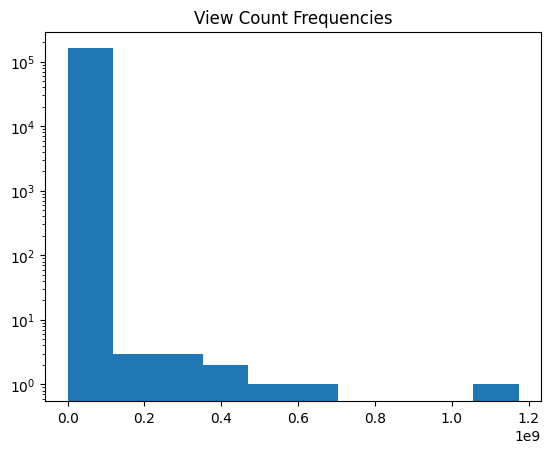

In [4]:
plt.hist(videos_df['view_count'], log=True)
plt.title("View Count Frequencies")
plt.show()

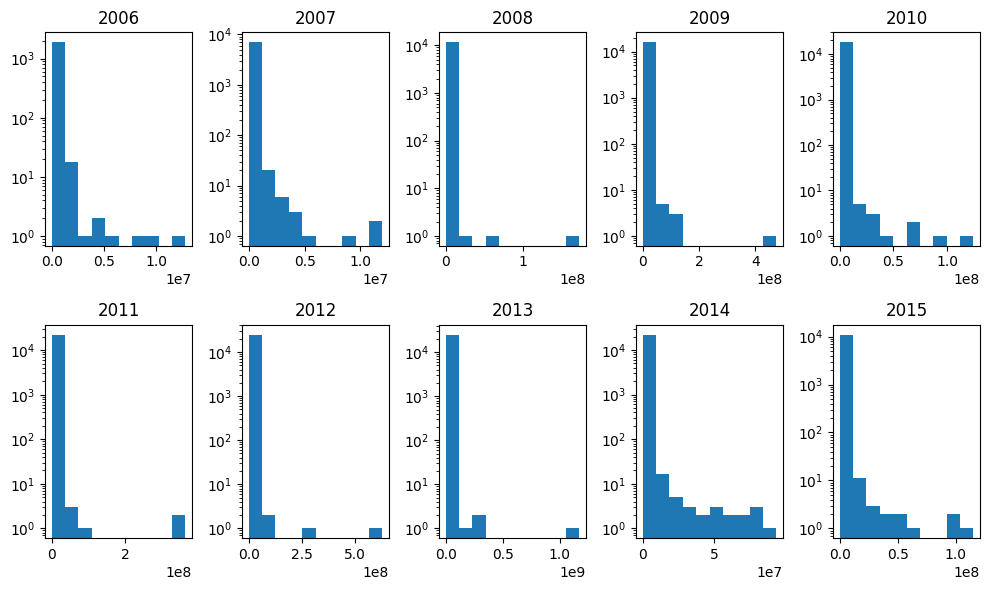

In [5]:
N_ROW = 2
N_COL = 5
fig, ax = plt.subplots(N_ROW, N_COL, figsize=(10,6))
row_idx = 0
col_idx = 0
for y in sorted(videos_df['year'].unique()):
    if y == 2005:
        continue
    df = videos_df[videos_df['year'] == y]
    ax[row_idx, col_idx].hist(df['view_count'], log=True)
    ax[row_idx, col_idx].set_title(y)
    col_idx += 1
    if col_idx >= N_COL:
        col_idx = 0
        row_idx += 1
fig.tight_layout()
plt.show()

In [6]:
videos_df.groupby('year')['view_count'].describe().sort_index()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2005,18.0,2.377419e+06,9.473490e+06,1927.0,9576.00,24022.0,254833.75,4.032444e+07
2006,1936.0,7.678088e+04,4.964322e+05,1006.0,2425.50,6456.0,21372.75,1.276256e+07
2007,7108.0,4.335839e+04,2.906554e+05,1004.0,2281.75,5333.5,17508.75,1.196398e+07
2008,11704.0,5.928809e+04,1.750528e+06,1005.0,2072.75,4466.0,14351.75,1.725084e+08
2009,16092.0,1.342406e+05,4.224389e+06,1009.0,2138.00,4651.5,14827.00,4.741977e+08
2010,18474.0,7.642411e+04,1.509112e+06,1012.0,2208.00,4757.5,15114.50,1.243583e+08
2011,22396.0,9.776753e+04,3.556521e+06,1005.0,2322.00,5046.0,16186.25,3.647104e+08
2012,24863.0,1.196577e+05,4.536057e+06,1005.0,2498.00,5566.0,17955.50,6.292990e+08
2013,25193.0,1.657417e+05,7.812914e+06,1011.0,2825.00,6449.0,22684.00,1.173649e+09


In [8]:
previous_columns = videos_df.columns
# DROP Years with less than 1000 videos in data set. This should fall away as dataset grows.
year_counts = videos_df['year'].value_counts()
keep_years = sorted(year_counts[year_counts >= 1000].index)
model_df = videos_df[videos_df['year'].isin(keep_years)].copy()
# Create categorical variables for labels that appear often enough
vocabulary = pd.read_csv("~/Downloads/vocabulary.csv").set_index("Index")
all_labels = [label for sublist in model_df['labels'] for label in sublist]
label_counts = pd.Series(all_labels).value_counts()
frequent_labels = label_counts[label_counts >= 200].index
for label in frequent_labels:
    model_df[label] = model_df['labels'].apply(lambda x: 1 if label in x else 0)
    label_mapping = vocabulary['Name'].to_dict()
    # Rename the columns using the text labels instead of numeric IDs
    model_df.rename(columns={label: label_mapping[label] for label in frequent_labels}, inplace=True)
label_columns = list(set(model_df.columns) - set(previous_columns))

/var/folders/lv/25xjrcz56zbgmhw5qtp1nwf80000gn/T/ipykernel_65600/529806626.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_df[label] = model_df['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/lv/25xjrcz56zbgmhw5qtp1nwf80000gn/T/ipykernel_65600/529806626.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_df[label] = model_df['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/lv/25xjrcz56zbgmhw5qtp1nwf80000gn/T/ipykernel_65600/529806626.py:12: PerformanceWarning: DataFrame is highly fr

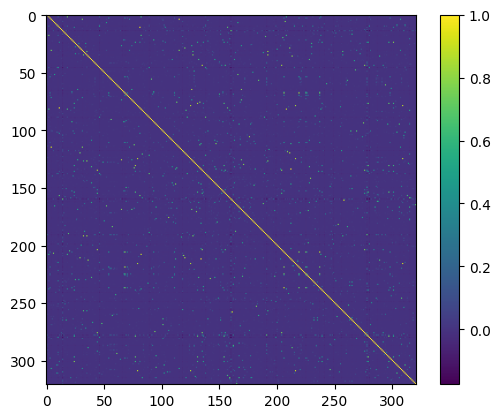

In [9]:
# Some features are very strongly correlated
plt.imshow(model_df[label_columns].corr())
plt.colorbar()
plt.show()

In [10]:
len(videos_df)

161049

In [10]:
# Use VIF to identify highly correlated features and remove to address multicollinearity
X_vif = model_df[[l for l in label_columns if l != 'year_categorical'] ]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(10)

,Feature,VIF
16,Bicycle,23.326329
10,Cycling,22.149744
39,Radio-controlled aircraft,18.481352
182,Model aircraft,17.384101
95,Pet,11.094633
155,Smartphone,9.852258
2,Mobile phone,9.412597
237,Radio-controlled model,8.172872
5,Vehicle,8.164156
22,Nail art,6.863042


In [11]:
# Based on VIF, I am removing the following columns:
# Cycling (correlated with Bicycle), Smartphone (correlated with Mobilephone), Model aircraft (correlated wtih Radio-controlled aircraft),
# Pet (Correlated with specific types of pets)

VIF_DROP_LABELS = ['Cycling', 'Smartphone', 'Model aircraft', 'Pet', 'nan']
label_columns = list(set(model_df.columns) - set(previous_columns))
label_columns = [re.sub(r'[^a-zA-Z_]', '', str(lc)) for lc in label_columns if lc not in VIF_DROP_LABELS]

In [12]:
len(label_columns)

310

In [13]:
model_df['year_categorical'] = model_df['year'].apply(str)
model_df.columns = model_df.columns.str.replace(r'[^a-zA-Z_]', '', regex=True)

/var/folders/lv/25xjrcz56zbgmhw5qtp1nwf80000gn/T/ipykernel_65600/2442173450.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_df['year_categorical'] = model_df['year'].apply(str)


# SHAP values and XGBoost

In [14]:
model_df['year_categorical'].unique()

array(['2015', '2013', '2014', '2009', '2010', '2008', '2011', '2012',
       '2007', '2006'], dtype=object)

In [15]:
videos_df.columns

Index(['youtube8m_id', 'youtube_id', 'url', 'labels', 'title', 'description',
       'channel_title', 'publish_time', 'tags', 'view_count', 'like_count',
       'favorite_count', 'comment_count', 'year', 'posted_day', 'quantile'],
      dtype='object')

# TRAIN PREDICTIVE MODELS TO EVALUATE MODEL PERFORMANCE

In [105]:
posted_day_dummies = pd.get_dummies(model_df["posted_day"], prefix="posted_day")
year_dummies = pd.get_dummies(model_df["year_categorical"], prefix="year")
df_model_full = pd.concat([model_df[["quantile"] + [lc for lc in label_columns if (lc != 'year_categorical') and (lc != 'nan')and (lc != 'youtubem_id')]], posted_day_dummies, year_dummies], axis=1)
# removing numeric characters leads to duplciate values for a few variables. Just collapse them together
NUMERIC_SUFFIX_VARS = ['CallofDutyModernWarfare', 'Xbox', 'PlayStation']
for v in NUMERIC_SUFFIX_VARS:
    col_locs = [i for i, col in enumerate(df_model_full.columns) if col == v]
    # If htere's anything present for that column, use that.
    df_model_full[v] = df_model_full.iloc[:, col_locs].max(axis=1)
    # Keep only first one, drop the rest.
    cols_to_drop = col_locs[1:]  # Keep the first one
    df_model_full.drop(df_model_full.columns[cols_to_drop], axis=1, inplace=True)

output_df = pd.DataFrame()
mae_results = dict()
for yr in keep_years:
    if yr+1 not in keep_years: # can't test the following year.
        break
    df_model = df_model_full[df_model_full[f"year_{yr}"]==1]
    # Train an XGBoost model for the year
    np.random.seed(1885)
    X_train = df_model_full[df_model_full[f"year_{yr}"]==1].iloc[:,1:]
    y_train = df_model_full[df_model_full[f"year_{yr}"]==1]["quantile"]
    X_test = df_model_full[df_model_full[f"year_{yr+1}"]==1].iloc[:,1:]
    y_test = df_model_full[df_model_full[f"year_{yr+1}"]==1]["quantile"]
    model = xgb.XGBRegressor(max_depth=10, n_estimators=1000, learning_rate=.02)
    model.fit(X_train, y_train)
    mae_results[yr] = (mean_absolute_error(y_train, model.predict(X_train)), mean_absolute_error(y_test, model.predict(X_test)), len(y_test))

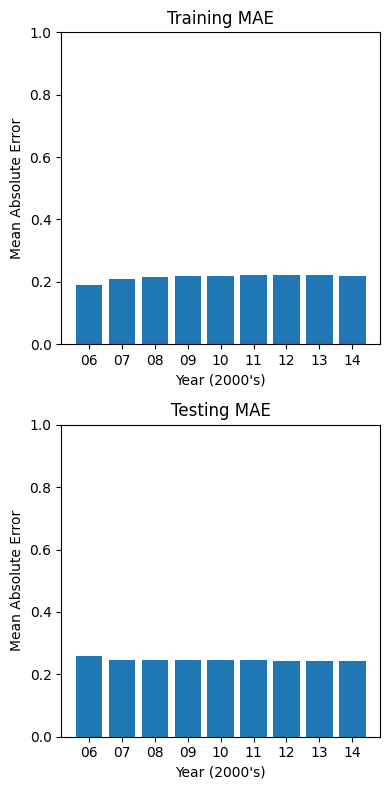

In [120]:
short_keep_years = [str(y)[2:] for y in mae_results.keys()]
fig, ax = plt.subplots(2,1, figsize=(4,8))
ax[0].bar(short_keep_years, [v[0] for v in mae_results.values()])
ax[0].set_xticks(short_keep_years)
ax[0].set_ylim([0,1])
ax[0].set_xlabel("Year (2000's)")
ax[0].set_ylabel("Mean Absolute Error")
ax[0].set_title("Training MAE")
ax[1].bar(short_keep_years, [v[1] for v in mae_results.values()])
ax[1].set_xticks(short_keep_years)
ax[1].set_ylim([0,1])
ax[1].set_xlabel("Year (2000's)")
ax[1].set_ylabel("Mean Absolute Error")
ax[1].set_title("Testing MAE")
plt.tight_layout()
fig.savefig("/Users/ryansloan/Desktop/mae.png")
plt.show()

In [111]:
mae_results

{2006: (0.1906905844001361, 0.2573850231857499, 7108),
 2007: (0.21029697511612372, 0.24648167927437306, 11704),
 2008: (0.21531511496711583, 0.24565232881462062, 16092),
 2009: (0.219497016281817, 0.2446286597841529, 18474),
 2010: (0.21939336417944663, 0.2454524537177559, 22396),
 2011: (0.2222345748122106, 0.2450267245989112, 24863),
 2012: (0.22329347345901973, 0.24344461251322602, 25193),
 2013: (0.22230431920946572, 0.24289447621115623, 22214),
 2014: (0.21972888502094187, 0.24251028648454087, 11051)}

In [114]:
# Summarize overall Test MAE
sum([mae_results[y][1]*mae_results[y][2] for y in mae_results.keys()])/sum([mae_results[y][2] for y in mae_results.keys()])

0.24503983944106014

# BUILD FULL FEATURE IMPORTANCES FOR VISUALIZATION

In [24]:
posted_day_dummies = pd.get_dummies(model_df["posted_day"], prefix="posted_day")
year_dummies = pd.get_dummies(model_df["year_categorical"], prefix="year")
df_model_full = pd.concat([model_df[["quantile"] + [lc for lc in label_columns if (lc != 'year_categorical') and (lc != 'nan')and (lc != 'youtubem_id')]], posted_day_dummies, year_dummies], axis=1)
# removing numeric characters leads to duplciate values for a few variables. Just collapse them together
NUMERIC_SUFFIX_VARS = ['CallofDutyModernWarfare', 'Xbox', 'PlayStation']
for v in NUMERIC_SUFFIX_VARS:
    col_locs = [i for i, col in enumerate(df_model_full.columns) if col == v]
    # If htere's anything present for that column, use that.
    df_model_full[v] = df_model_full.iloc[:, col_locs].max(axis=1)
    # Keep only first one, drop the rest.
    cols_to_drop = col_locs[1:]  # Keep the first one
    df_model_full.drop(df_model_full.columns[cols_to_drop], axis=1, inplace=True)

output_df = pd.DataFrame()
for yr in keep_years:
    df_model = df_model_full[df_model_full[f"year_{yr}"]==1]
    # Train an XGBoost model for the year
    X = df_model.iloc[:, 1:]
    y = df_model["quantile"]
    model = xgb.XGBRegressor()
    model.fit(X, y)
    # Evaluate feature importance using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    
    #shap.summary_plot(shap_values, X, max_display=25, alpha=.1)
    shap_df = pd.DataFrame(shap_values.values, columns=df_model.columns[1:])
    filtered_shap_values = shap_df*df_model[df_model.columns[1:]].reset_index(drop=True).replace(0, np.nan)
    reshaped_df = filtered_shap_values.melt(var_name='variable', value_name='value')
    print(len(reshaped_df))
    reshaped_df = reshaped_df.dropna()
    print(len(reshaped_df))
    reshaped_df['year'] = yr
    output_df = pd.concat([output_df, reshaped_df])

617584
37197
2267452
137060
3733576
225870
5133348
310568
5893206
356334
7144324
431256
7931297
478209
8036567
484698
7086266
427733
3525269
213399


In [26]:
X.shape

(11051, 319)

In [25]:
output_df[~output_df['variable'].str.contains('year')].to_csv("../dashboard/shap_values.csv", index=False)